In [1]:
!pip install torchvision timm


[notice] A new release of pip available: 22.3.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

# ℹ️ Load Data

In [3]:
class PlayingCardDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

    @property
    def classes(self):
        return self.data.classes

In [4]:
dataset = PlayingCardDataset(
    data_dir='./archive/train'
)

In [5]:
len(dataset)

7624

In [6]:
dataset[5]

(<PIL.Image.Image image mode=RGB size=224x224>, 0)

In [7]:
image, label = dataset[6000]

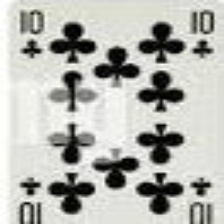

In [8]:
image

In [9]:
# Create a dictionary of labels for each number in the dataset
data_dir = './archive/train'
target_to_class = {v: k for k, v in ImageFolder(data_dir).class_to_idx.items()}
print(target_to_class)

{0: 'ace of clubs', 1: 'ace of diamonds', 2: 'ace of hearts', 3: 'ace of spades', 4: 'eight of clubs', 5: 'eight of diamonds', 6: 'eight of hearts', 7: 'eight of spades', 8: 'five of clubs', 9: 'five of diamonds', 10: 'five of hearts', 11: 'five of spades', 12: 'four of clubs', 13: 'four of diamonds', 14: 'four of hearts', 15: 'four of spades', 16: 'jack of clubs', 17: 'jack of diamonds', 18: 'jack of hearts', 19: 'jack of spades', 20: 'joker', 21: 'king of clubs', 22: 'king of diamonds', 23: 'king of hearts', 24: 'king of spades', 25: 'nine of clubs', 26: 'nine of diamonds', 27: 'nine of hearts', 28: 'nine of spades', 29: 'queen of clubs', 30: 'queen of diamonds', 31: 'queen of hearts', 32: 'queen of spades', 33: 'seven of clubs', 34: 'seven of diamonds', 35: 'seven of hearts', 36: 'seven of spades', 37: 'six of clubs', 38: 'six of diamonds', 39: 'six of hearts', 40: 'six of spades', 41: 'ten of clubs', 42: 'ten of diamonds', 43: 'ten of hearts', 44: 'ten of spades', 45: 'three of clu

In [10]:
# Output images in same size
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

In [11]:
# Create dataset
dataset = PlayingCardDataset(data_dir, transform)

In [12]:
# Image is now a PyTorch tensor instead of a PIL image
image, label = dataset[100]
image.shape

torch.Size([3, 128, 128])

In [13]:
# Iterate over the dataset
for image, label in dataset:
    break

# 📀 Create DataLoaders for PyTorch Model

In [14]:
# Shuffle when training
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [15]:
for images, labels in dataloader:
    break

In [16]:
images.shape, labels.shape

(torch.Size([32, 3, 128, 128]), torch.Size([32]))

In [17]:
labels

tensor([31, 50,  9, 18, 11, 46, 14, 25, 23,  4,  0, 23, 35,  9, 22, 27, 34, 22,
        31, 42, 14,  7,  7, 32, 20, 15, 47,  0, 15, 28,  7, 25])

# 🤖 Create PyTorch Model

In [18]:
# timm has state of the art architectures pre-defined
class SimpleCardClassifier(nn.Module):
    def __init__(self, num_classes=53):
        super(SimpleCardClassifier, self).__init__()
        self.base_model = timm.create_model('efficientnet_b0', pretrained=True)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])
        
        enet_out_size = 1280
        # Make a classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(enet_out_size, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        output = self.classifier(x)
        return output

In [19]:
model = SimpleCardClassifier(num_classes=53)
print(str(model)[:500])

SimpleCardClassifier(
  (base_model): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=Fa


In [20]:
example_output = model(images)
example_output.shape # [batch_size, num_classes]

torch.Size([32, 53])

# 🧠 Train the Model

In [21]:
# Loss function
criterion = nn.CrossEntropyLoss()
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [30]:
train_folder = './archive/train'
test_folder = './archive/test'
val_folder = './archive/valid'

In [31]:
train_dataset = PlayingCardDataset(train_folder, transform=transform)
val_dataset = PlayingCardDataset(val_folder, transform=transform)
test_dataset = PlayingCardDataset(test_folder, transform=transform)

In [32]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [33]:
num_epoch = 5
train_losses, val_losses = [], []

model = SimpleCardClassifier(num_classes=53)

In [47]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(device)

mps


In [57]:
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epoch):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc='Training loop'):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation phase
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validation loop'):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
    val_loss = running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)

    # print each epoch
    print(f'Epoch {epoch+1}/{num_epoch} - Train loss: {train_loss}, Validation Loss: {val_loss}')

Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/5 - Train loss: 1.563692478355556, Validation Loss: 0.5065072698413201


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 2/5 - Train loss: 0.5469550037559157, Validation Loss: 0.2200782742140428


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 3/5 - Train loss: 0.32280133089201146, Validation Loss: 0.19810970166944109


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 4/5 - Train loss: 0.23122494403519134, Validation Loss: 0.21681743612829243


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 5/5 - Train loss: 0.1835515905496081, Validation Loss: 0.2560482494111331


#  📉 Visualize Losses

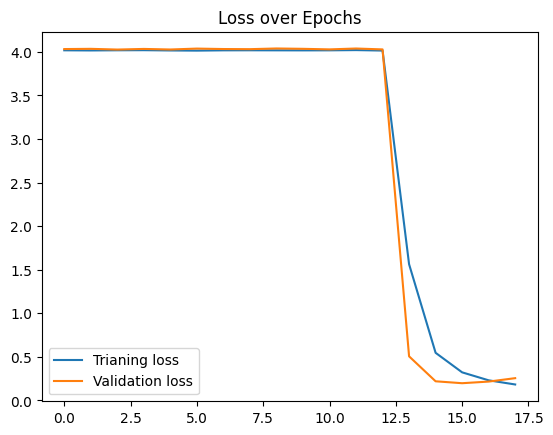

In [58]:
plt.plot(train_losses, label='Trianing loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title('Loss over Epochs')
plt.show()

# 🎓 Evaluate Model

In [59]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [60]:
# Load an dpreprocess the image
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert('RGB')
    return image, transform(image).unsqueeze(0)

In [61]:
# Predict using the model
def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy().flatten()

In [62]:
# Visualization
def visualize_predictions(original_image, probabilities, class_names):
    fig, axarr = plt.subplots(1, 2, figsize=(14, 7))

    # Display image
    axarr[0].imshow(original_image)
    axarr[0].axis('off')

    # Display prediction
    axarr[1].barh(class_names, probabilities)
    axarr[1].set_xlabel('Probability')
    axarr[1].set_ylabel('Class Predictions')
    axarr[1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

In [63]:
# Example usage
test_image = './archive/test/five of diamonds/2.jpg'
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

original_image, image_tensor = preprocess_image(test_image, transform)
probabilities = predict(model, image_tensor, mps_device)

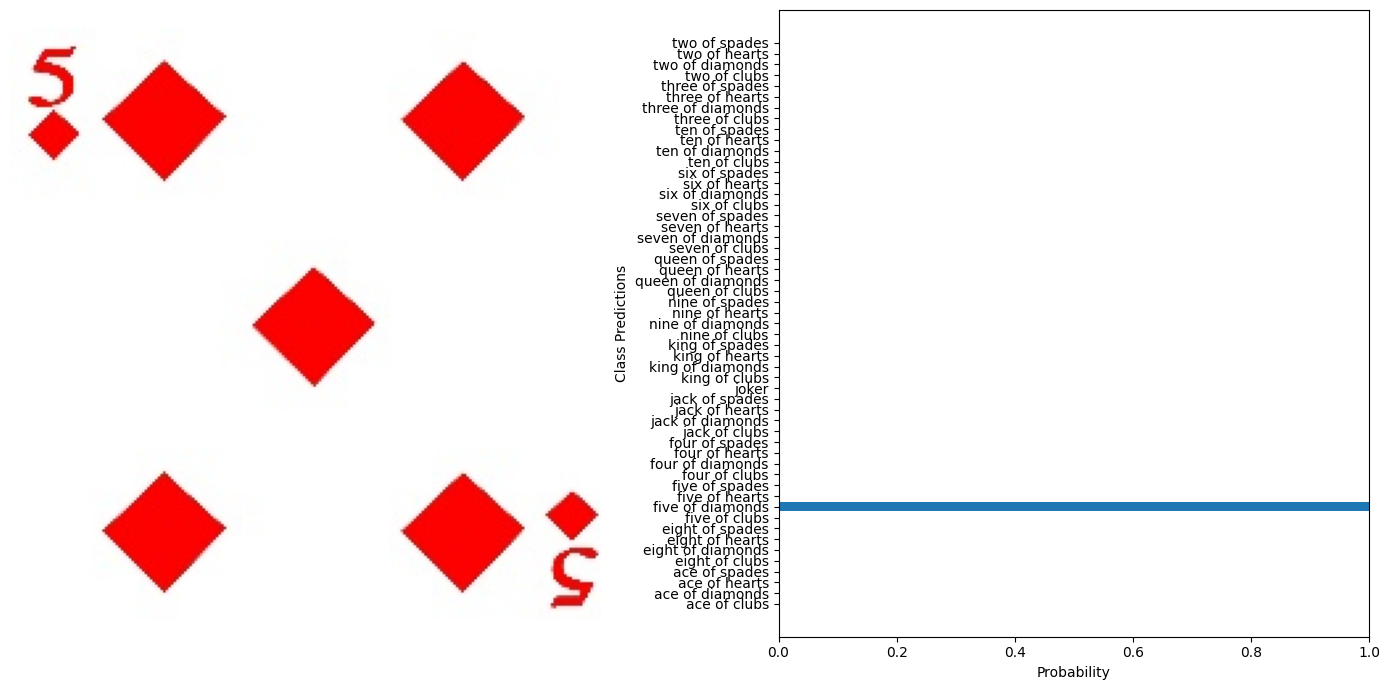

In [64]:
# Assuming dataset.classes gives the class names
class_names = dataset.classes
visualize_predictions(original_image, probabilities, class_names)

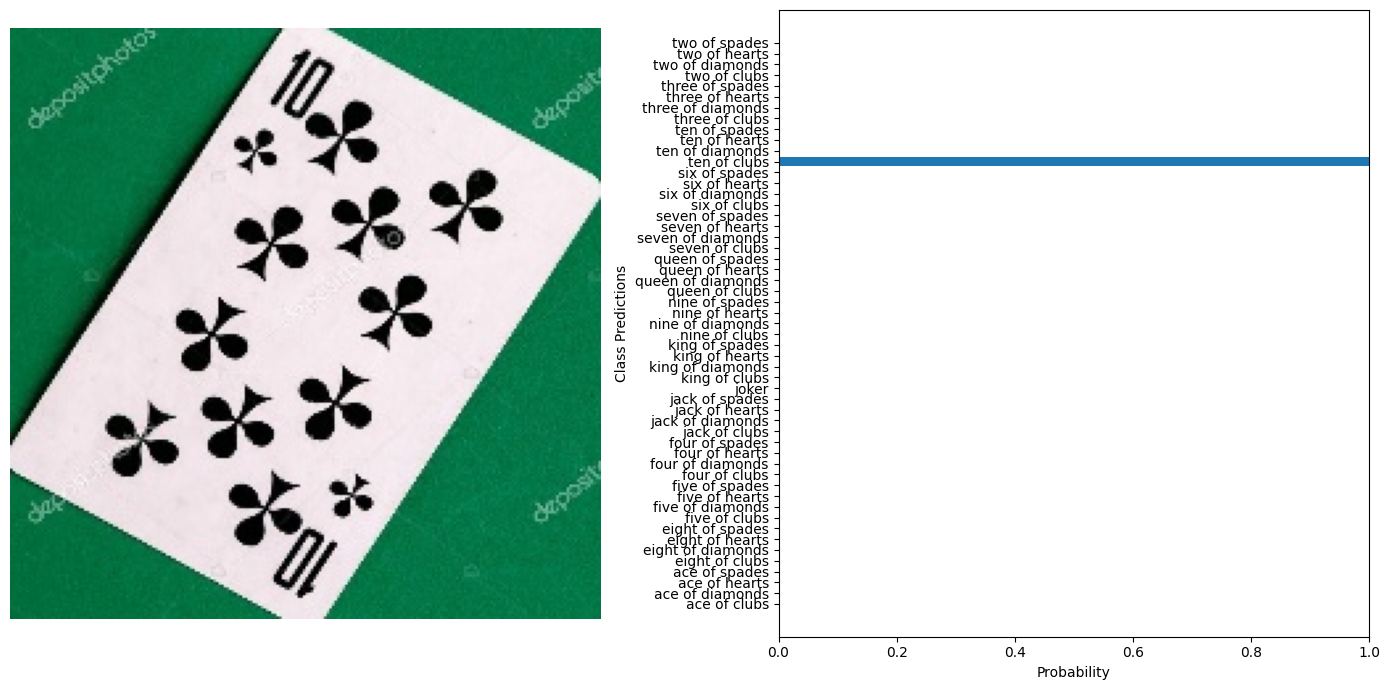

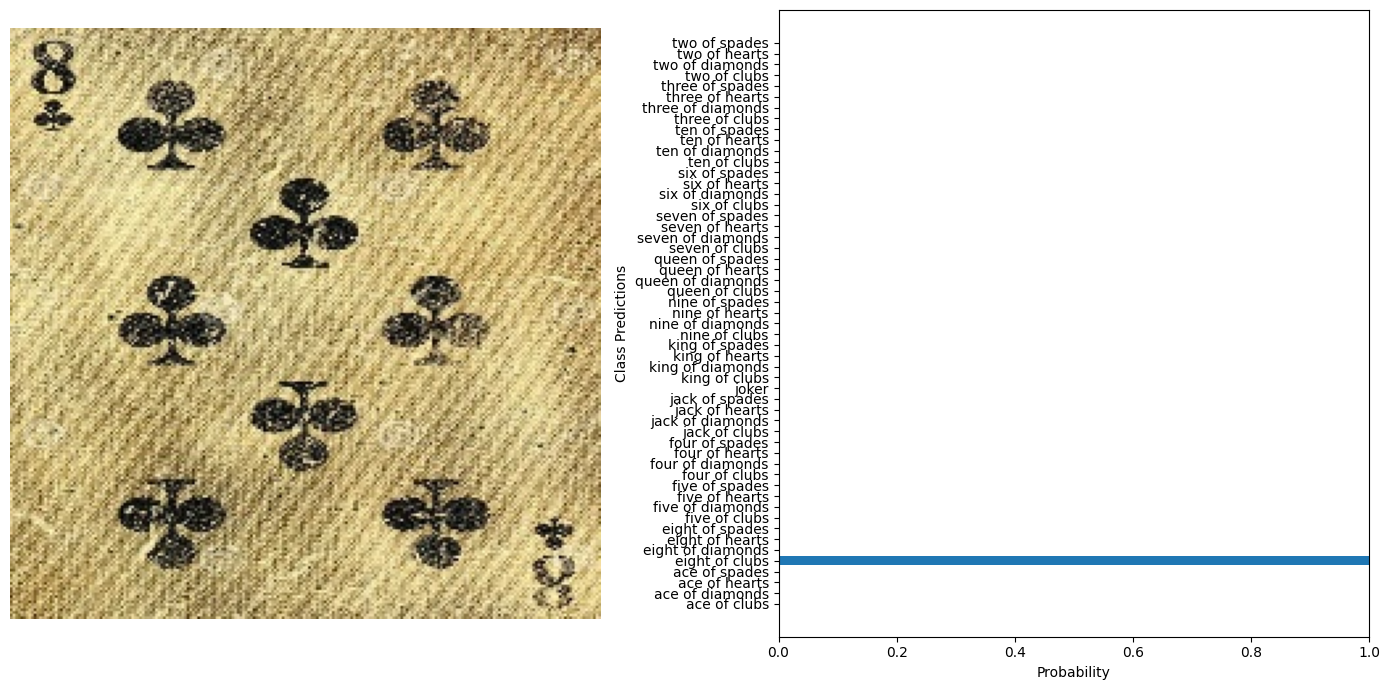

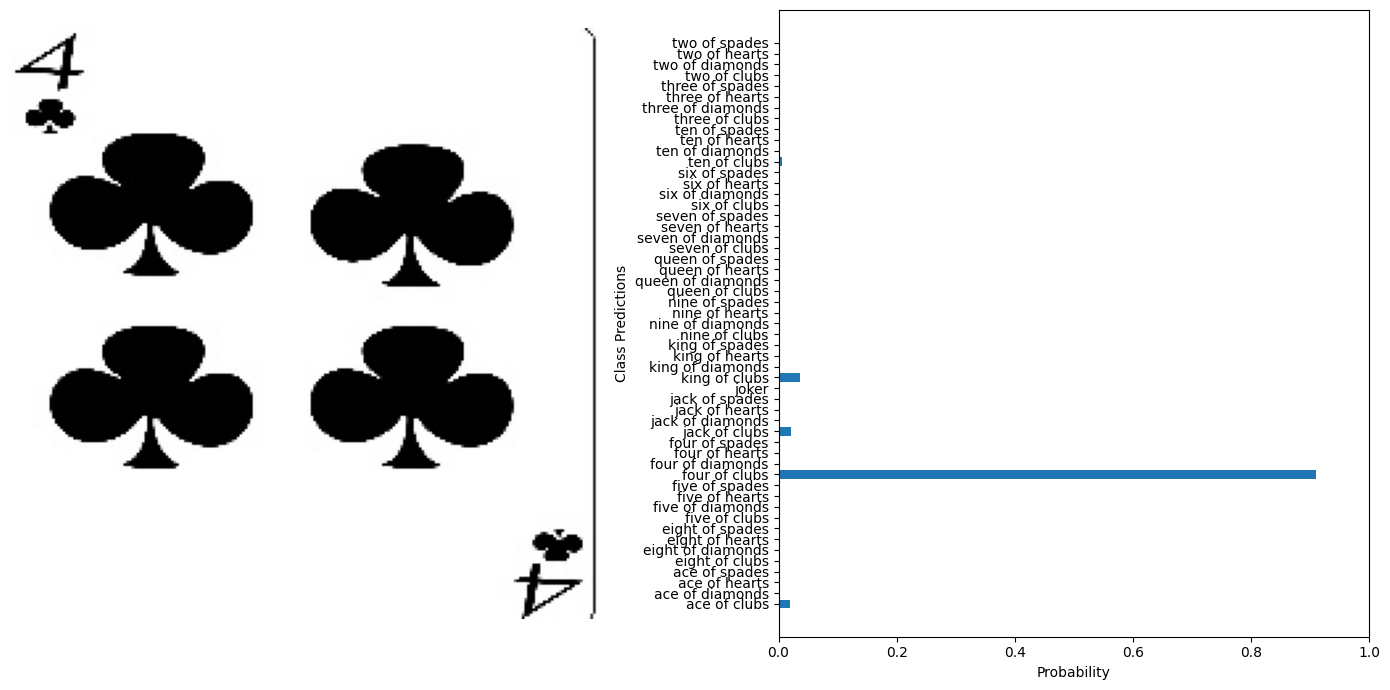

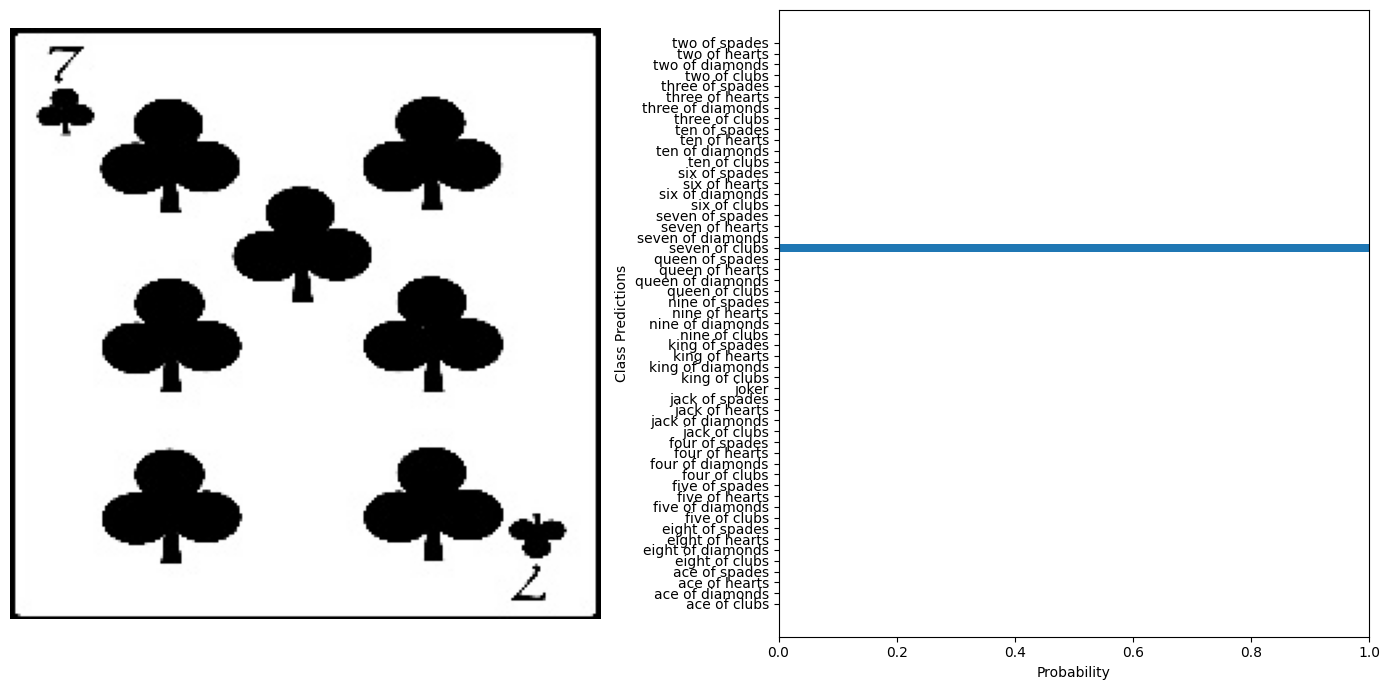

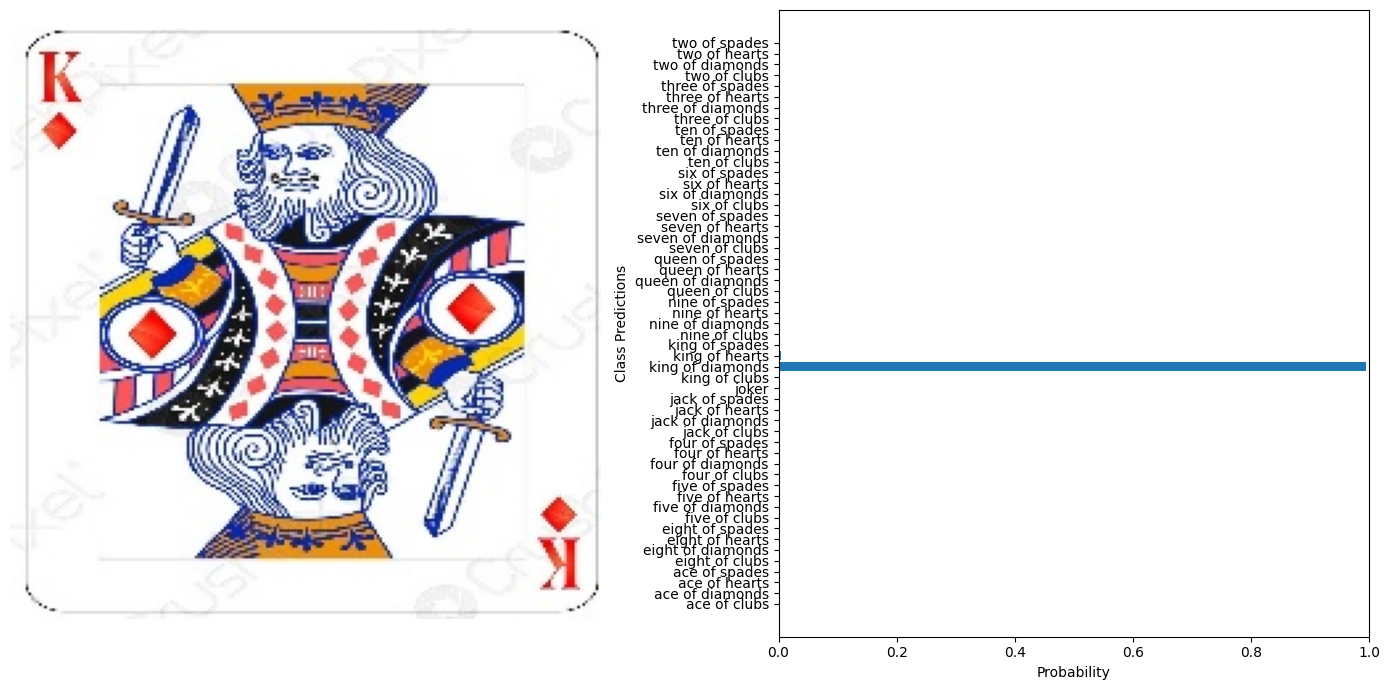

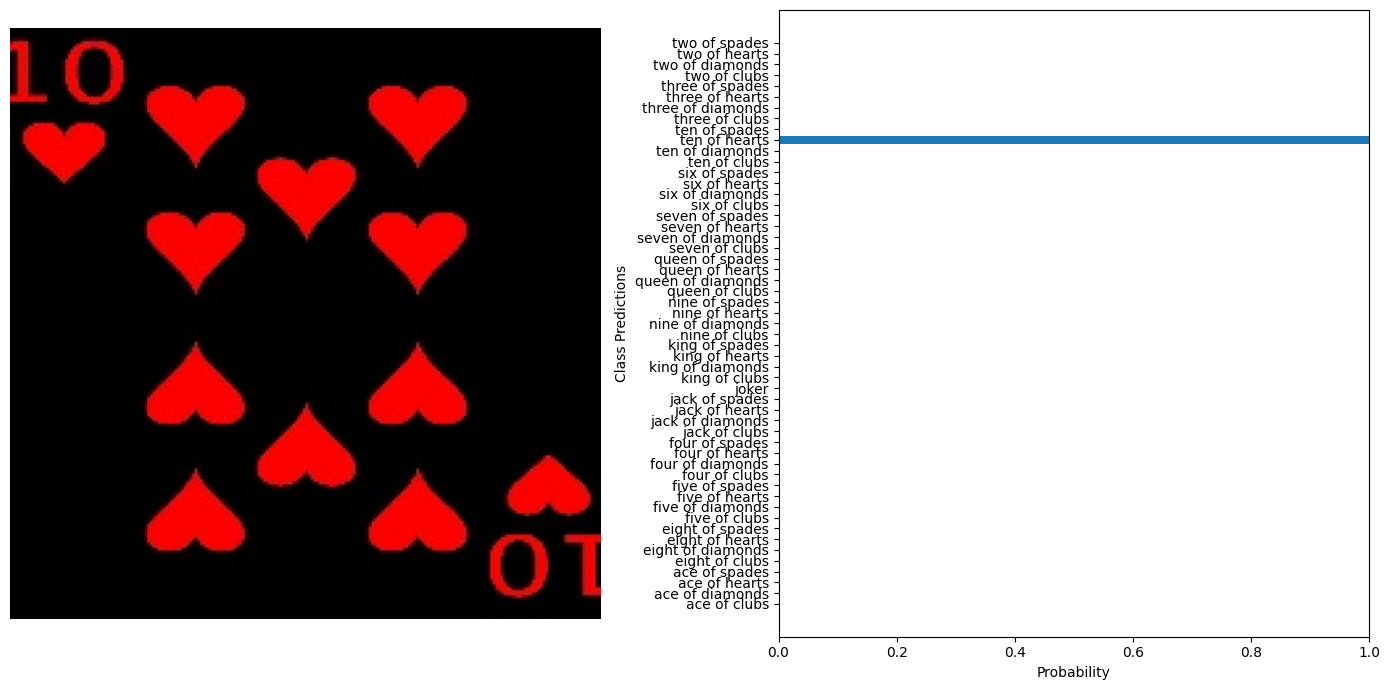

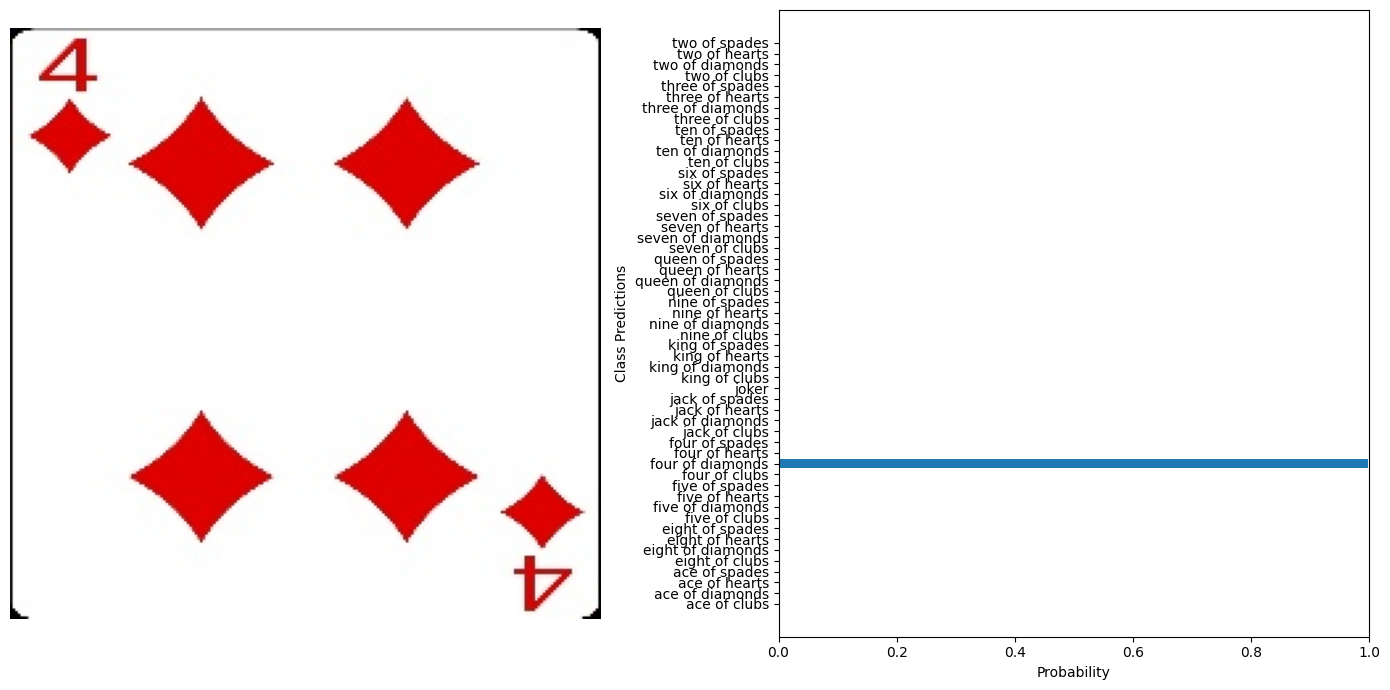

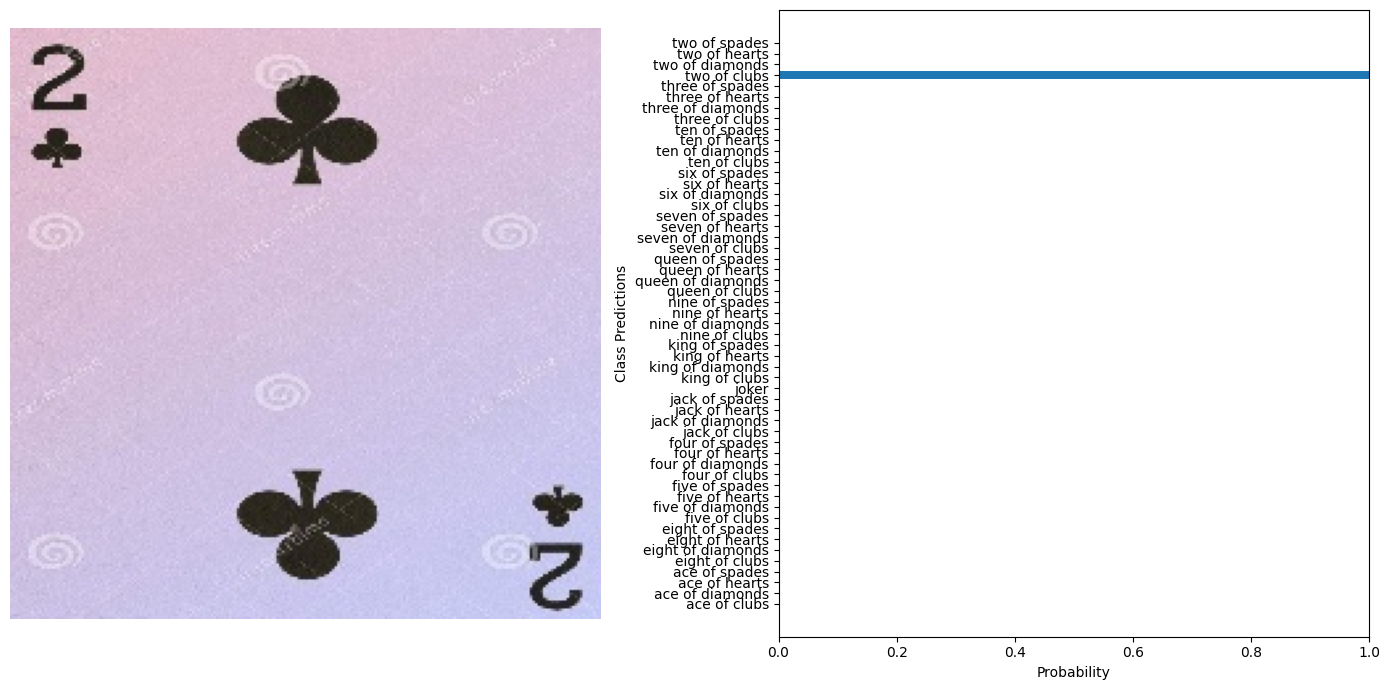

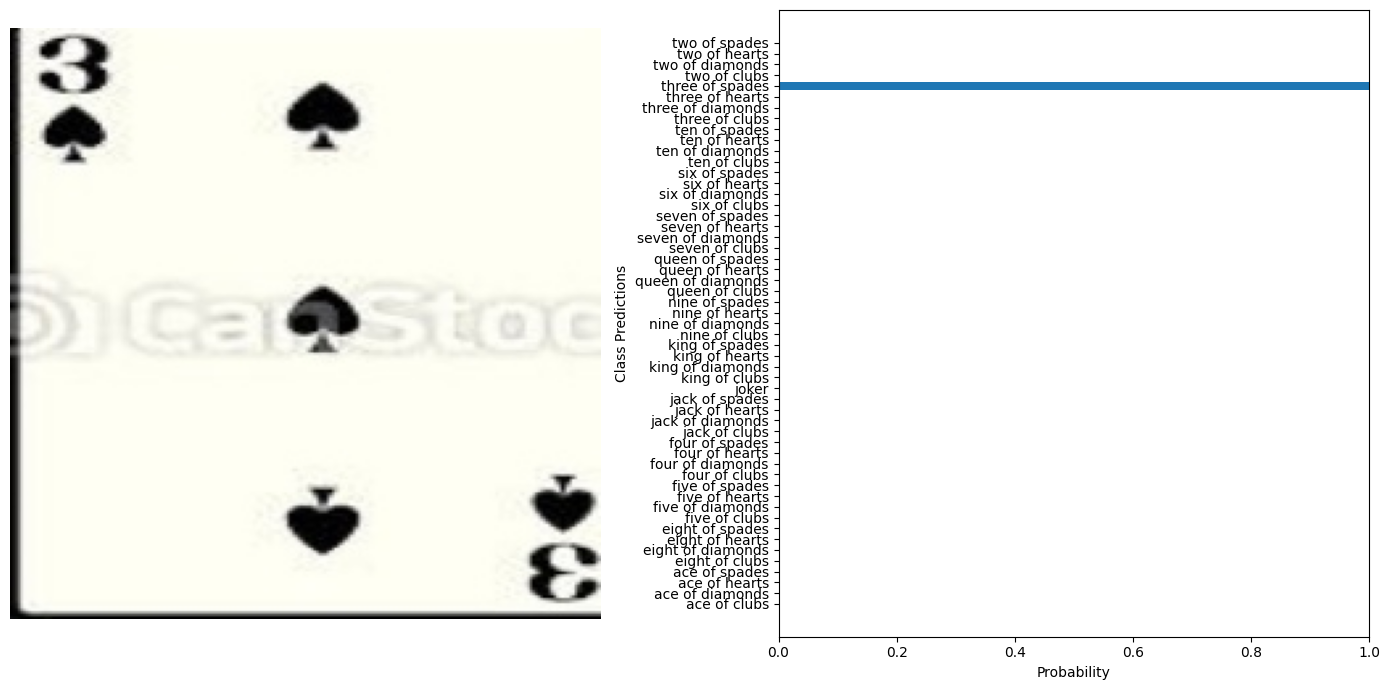

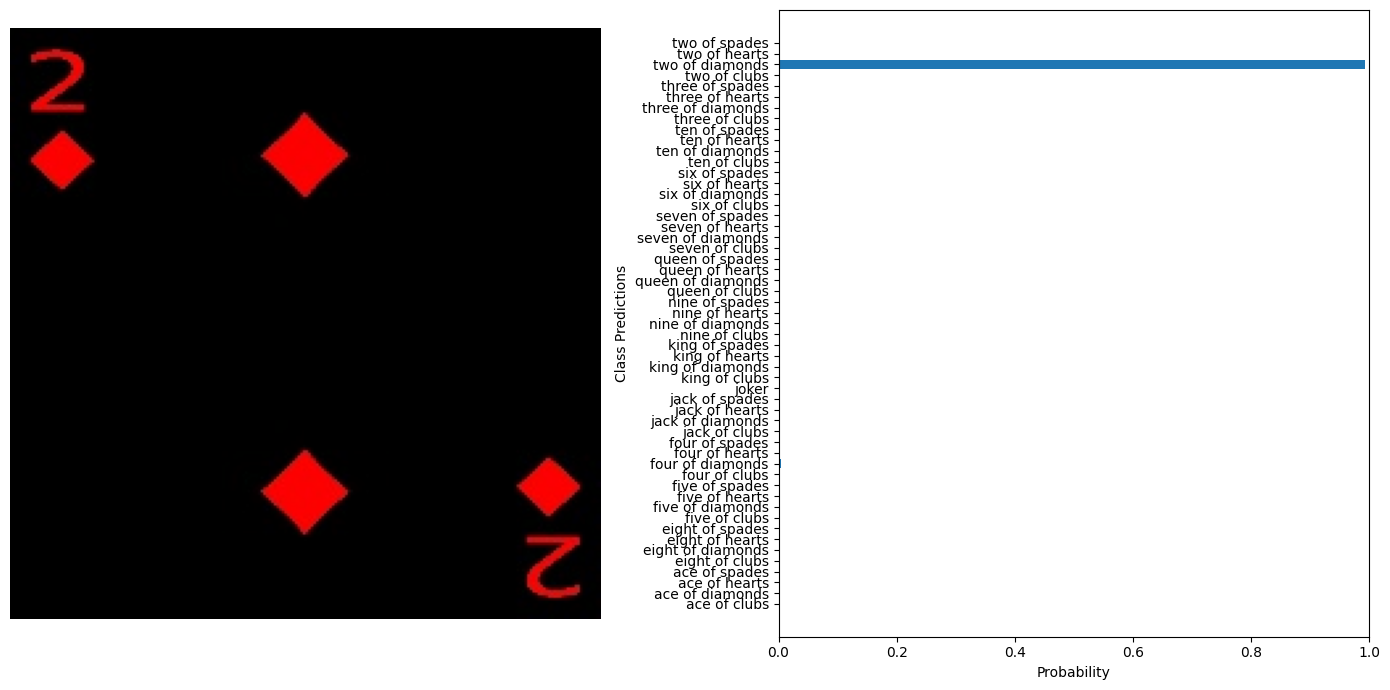

In [65]:
from glob import glob
test_images = glob('./archive/test/*/*')
test_examples = np.random.choice(test_images, 10)

for example in test_examples:
    original_image, image_tensor = preprocess_image(example, transform)
    probabilities = predict(model, image_tensor, mps_device)

    class_names = dataset.classes
    visualize_predictions(original_image, probabilities, class_names)

In [70]:
# Calculate model accuracy
def calculate_accuracy(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, prediction = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (prediction == labels).sum().item()
    return correct / total * 100

In [75]:
test_accuracy = calculate_accuracy(model, test_loader, device)
print(f'Test Accuracy: {test_accuracy:.02f}%')

Test Accuracy: 93.21%
